In [1]:
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from scipy import special
plt.rcParams['figure.figsize'] = [14, 11]

In [2]:
path = 'CIV/FAIRALL9/CIV.bin3.linespec' 
wl, fl, fe, ctn = np.loadtxt(path).transpose()  # is there a line spread function in this new format ?
fn = fl / ctn
fne = fe / ctn


lsf = np.loadtxt('FAIRALL9/CIV.lsf') 

In [3]:
wl1, f1, gamma1, elem, state = (1548.187, 0.19, 0.00324, 'C', 'IV')
wl2, f2, gamma2, elem, state = (1550.772, 0.0952, 0.00325, 'C', 'IV')

In [4]:
def V2Wave(v, wlr):
    return ((v * (1e-13 *wlr) / 3e5) + (wlr * 1e-13))*1e13

def Wave2V(wl, wlr):
    return ((wl / 1e13) - (wlr * 1e-13)) * 3e5 / (1e-13 *wlr)

In [5]:
def model(p0):
    m = np.ones(wl.shape)
    
    Ncomp = len(p0)//3
    for comp_i in range(Ncomp):
        N, b, vc = p0[comp_i*3: comp_i*3+3]
        m1 = m*vline(Wave2V(wl, wl1), [b/1.414, gamma1, N2tau(10**N, wl1, f1), vc, 1])
        m2 = m*vline(Wave2V(wl, wl2), [b/1.414, gamma2, N2tau(10**N, wl2, f2), vc, 1])
        m*= m1 * m2
    
    m = convolve(m, lsf)
    return m

def fitting(p0):
    #m1, m2 = model(p0)
    m = model(p0)
    
    #chi1 = (fn1 - m1) / fne1
    #chi2 = (fn2 - m2) / fne2
    chi = (fn - m) / fne

    #chi1 = chi1[(v1 < 200) & (v1 > -200)]
    #chi2 = chi2[(v2 < 200) & (v2 > -200)]
    chi1 = chi[(wl > 1547) & (wl < 1550)]
    chi2 = chi[(wl > 1550) & (wl < 1553)]
    
    return np.append(chi1, chi2)



In [6]:
def convolve(model, lsf):
    Nlsf = len(lsf) // 2
    ext_model = np.append(np.ones(Nlsf)*model[0], model)
    ext_model = np.append(ext_model, np.ones(Nlsf)*model[-1])
    cmodel = np.convolve(ext_model, lsf, 'valid')
    return cmodel

def N2tau(N, wlr, f):
    tau = N * 2.654e-15 * f * wlr
    return tau

def vline(x, p):
    '''
    p = [sigma, gamma, tau, v0, covering_factor]
    saturated_factor is a newly defined parameter to describe the thermal radiation varying in 0 to 1.
    The simplified model is c_f * exp(-tau) + (1-c_f).
    '''
    x = np.array(x)
    pro = abs(p[2]) * Voigt(x, p[3], p[0], abs(p[1]))

    return abs(p[4]) * np.exp(-pro) + (1 - abs(p[4]))

def Voigt(x, x0, sigma, gamma):
    '''
    x should be an array.
    sigma is the Doppler parameter.
    gamma is the Gaussian sigma.
    x0 is the center position.
    '''
    z = ((x-x0) + 1j * abs(gamma)) / abs(sigma) / 2**0.5

    return (special.wofz(z)).real/abs(sigma)/(2*np.pi)**0.5



In [7]:
x0 = [13.5, 20.3, -20] + [13.5, 20.3, 40] + [13, 20.3, 150] + [13, 20.3, 170]
p0, cov, a, b, c = leastsq(fitting, x0, full_output=1)



[ 12.57495466  26.7782259   16.82237721  12.69681595  15.2931771
  73.04097893  13.16612512  28.62536362 142.63829701  13.04423733
  11.72532946 196.07237207]
[13.99609822, 25.90802024, 16.77461055, 13.65319377, 15.54467844, 72.76245258, 13.62613243, 27.63994518, 142.93988578, 12.99182313, 6.41927032, 193.13413713]


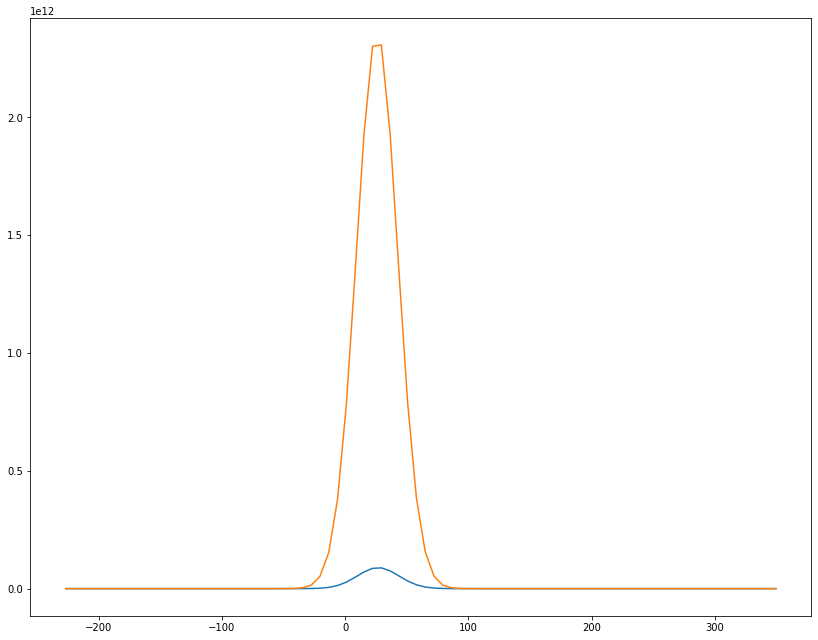

In [8]:
p1 = [ 13.99609822,  25.90802024,  16.77461055,  13.65319377,  15.54467844, 72.76245258,  13.62613243,  
      27.63994518, 142.93988578,  12.99182313, 6.41927032, 193.13413713]  # from the fitting over velocity 

v1 = Wave2V(wl[(wl > 1547) & (wl < 1550)], wl1)

N1 = Voigt(v1, p0[1], p0[2], gamma1)
N11 = Voigt(v1, p1[1], p1[2], gamma1)

plt.plot(v1, 10**p0[0] * N1)
plt.plot(v1, 10**p1[0] * N11)
print(p0)
print(p1)

In [9]:
def plot_model(p0):
    m = model(p0)
    plt.step(wl, fn, 'k-', lw=2, where='mid')
    plt.plot(wl, m, 'r--', lw=2)
    
    Ncomp = len(p0)//3
    
    for comp_i in range(Ncomp):
        N, b, vc = p0[comp_i*3: comp_i*3+3]
        m1 = vline(Wave2V(wl, wl1), [b/1.414, gamma1, N2tau(10**N, wl1, f1), vc, 1])
        m2 = vline(Wave2V(wl, wl2), [b/1.414, gamma2, N2tau(10**N, wl2, f2), vc, 1])
        m = m1 * m2
        m = convolve(m, lsf)
        plt.plot(wl, m, 'y:', lw=2)
    
    plt.xlim(1547, 1553)
    plt.show()



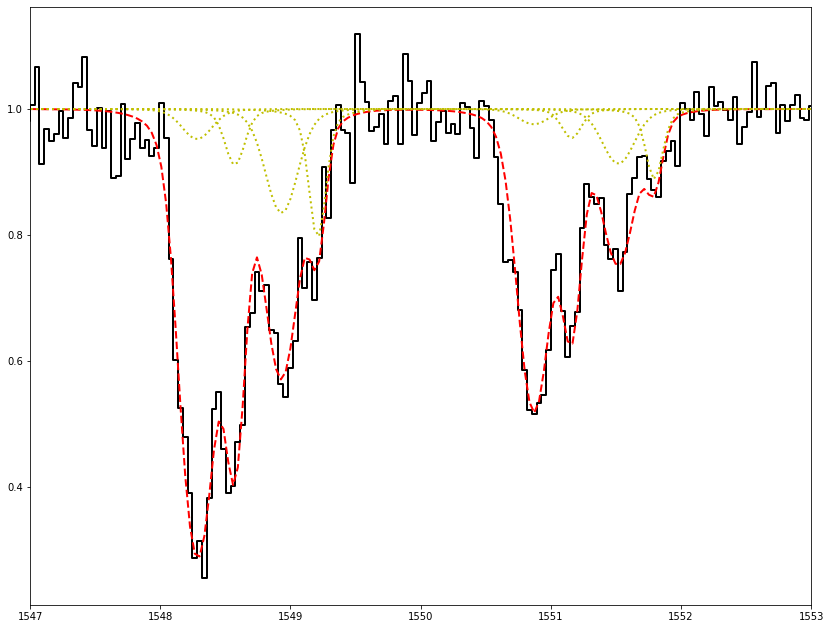

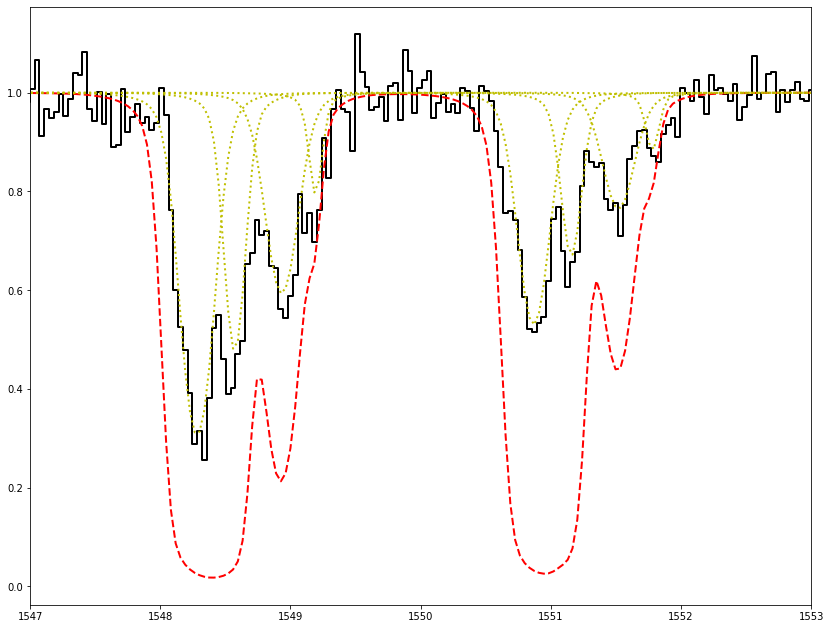

In [10]:
plot_model(p0)
plot_model(p1)

In [11]:
def make_features(p0):    
    length = len(p0) // 3
    Ns_tot = 0
    Nw_tot = 0 
    for i in range(length):
        Ns_tot += 10**(p0[3 * i])*Voigt(Wave2V(wl, wl1), p0[2 + 3*i], p0[1 + 3*i]/np.sqrt(2), gamma1)
        Nw_tot += 10**(p0[3 * i])*Voigt(Wave2V(wl, wl2), p0[2 + 3*i], p0[1 + 3*i]/np.sqrt(2), gamma1)
    Ns = convolve(Ns_tot, lsf)
    Nw = convolve(Nw_tot, lsf)
    return Ns, Nw

(-200, 300)

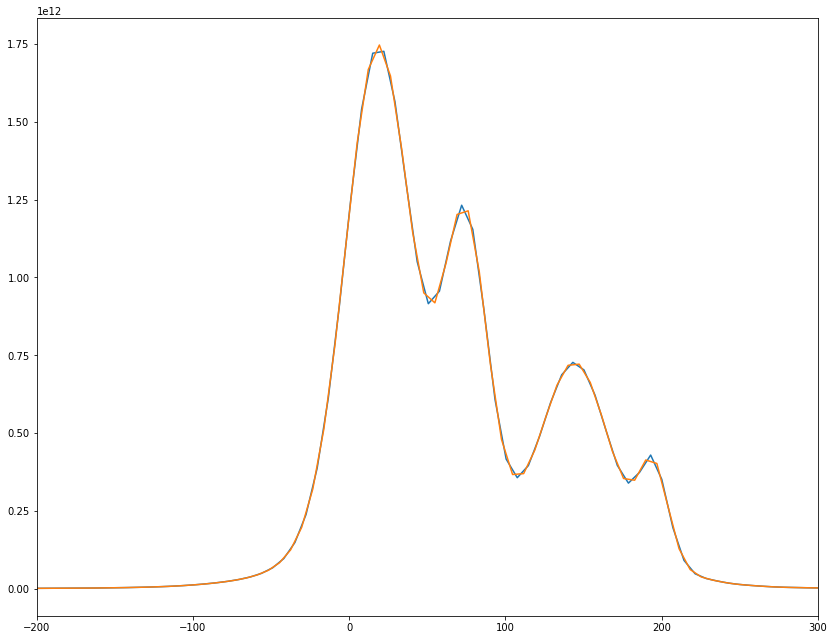

In [12]:
v1 = Wave2V(wl[(wl > 1547) & (wl < 1550)], wl1)
v2 = Wave2V(wl[(wl > 1549.5) & (wl < 1552.5)], wl2)


N1, N2 = make_features(p1)
plt.plot(Wave2V(wl, wl1), N1)
plt.plot(Wave2V(wl, wl2), N2)
plt.xlim(-200,300)

In [13]:
def add_residual(p0, N1, N2):
    m = model(p0)
    r = fn / m
    N1 += N_v(r, wl1, f1)
    N2 += N_v(r, wl2, f2)
    return N1, N2

def N_v(fn, wlr, f):
    return -np.log(fn)/wlr/f/2.654e-15

def nfle2Nev(nfl, nfle, f, wlr):      # calculte error in the column density 
    Nev = nfle/nfl / 2.654e-15/f/wlr
    return Nev     

In [14]:
Ne1 = nfle2Nev(fn, fne, f1, wl1)
Ne2 = nfle2Nev(fn, fne, f2, wl2)
N1r, N2r = add_residual(p0, N1, N2)

(-200, 300)

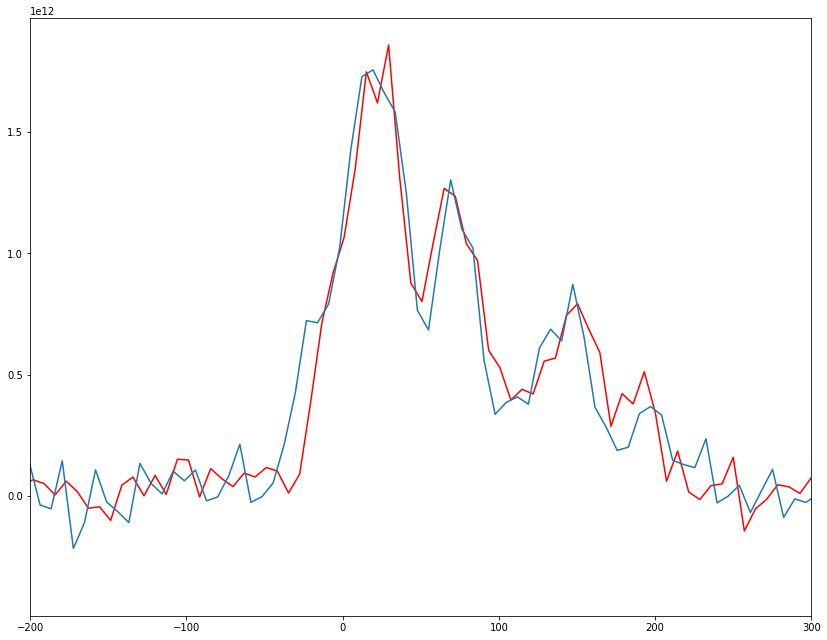

In [15]:
plt.plot(Wave2V(wl, wl1), N1r, 'r')
plt.plot(Wave2V(wl, wl2), N2r)
plt.xlim(-200,300)

In [16]:
flag1 = (wl > 1547) & (wl < 1550)
flag2 = (wl > 1549.5) & (wl < 1552.5)

v1 = Wave2V(wl, wl1)[flag1]
v2 = Wave2V(wl, wl2)[flag2]

Nv1 = N1r[flag1]
Nv2 = N2r[flag2]

Nve1 = Ne1[flag1]
Nve2 = Ne2[flag2]

In [17]:
feature_flag2 = np.invert((v2 > -45) & (v2 < -10)) # to get rid of this feature 

In [18]:
v2 = v2[feature_flag2]
Nv2 = Nv2[feature_flag2]
Nve2 = Nve2[feature_flag2]

In [19]:
Nv = np.append(Nv1, Nv2)
Nve = np.append(Nve1, Nve2)
v = np.append(v1, v2)

In [20]:
idx = np.argsort(v)
v_sorted = v[idx]
Nv_sorted = Nv[idx]
Nve_sorted = Nve[idx]

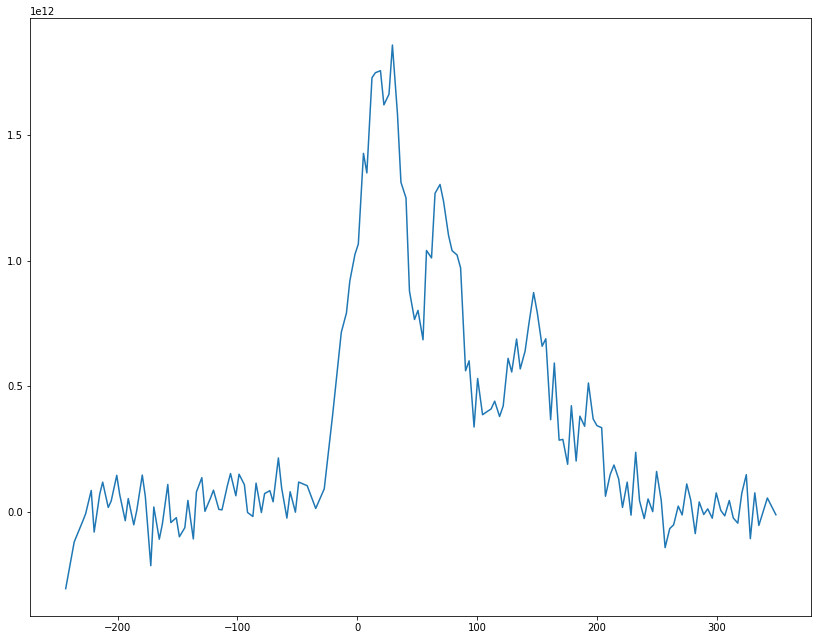

In [21]:
plt.plot(v_sorted, Nv_sorted)

In [22]:
New_v = np.linspace(-400, 400, 101) # dv ~ 8
indices = np.searchsorted(v_sorted, New_v)
v_bins = np.split(v_sorted, indices)

In [23]:
def final_data(v_bins, Nv_sorted, Nve_sorted):
    include = []
    for b in v_bins:
        include.append(len(b) > 0)
        
    v_fin = []
    N_fin = []
    err_fin = []
    
    v_temp = 0
    i = 0
    num = 0
    index = 0
    Ne_temp = 0
    N_temp = 0
    err_temp = 0
    
    for b in v_bins:
        if (include[i] == True):
            for v in b:
                v_temp += v
                num += 1
                N_temp += (Nv_sorted[index] * Nve[index])
                Ne_temp += Nve[index]
                err_temp += Nve_sorted[index]**2
                index += 1
            v_fin.append(v_temp / num)
            v_temp = 0
            num = 0
            N_fin.append(N_temp / Ne_temp)
            N_temp = 0
            Ne_temp = 0
            err_fin.append(np.sqrt(err_temp))
            err_temp = 0
        i += 1
        
    return v_fin, N_fin, err_fin

In [24]:
v_final, Nv_final, Nve_final = final_data(v_bins, Nv_sorted, Nve_sorted)

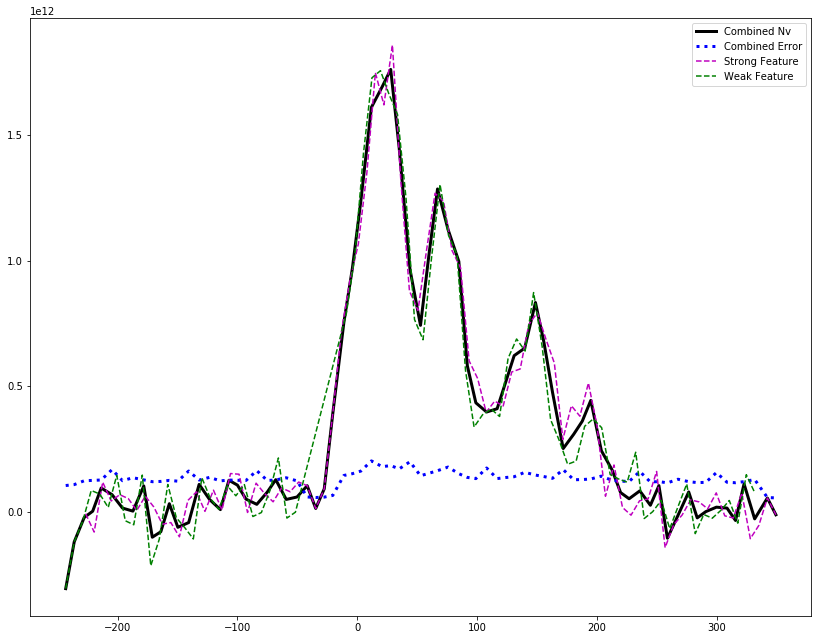

In [27]:
plt.plot(v_final, Nv_final,'k-', lw=3, label='Combined Nv')
plt.plot(v_final, Nve_final, 'b:', lw=3, label='Combined Error')
plt.plot(v1, Nv1, '--m', label='Strong Feature')
plt.plot(v2, Nv2, '--g', label='Weak Feature')
plt.legend()